In [1]:
import numpy as np
import torch
#import models.u_transformers_2D as ut2d
import models.mymod.UNet as unet
import matplotlib.pyplot as plt

## patched unet

In [2]:
mod = unet.Patched3DUNet(patch_size=(16,16,16), filters=(2,4,8,16,32), n_classes=2, in_channels=1)

bs, c, x, y, z = 1,1,16*12,16*12,15*10
inp = torch.from_numpy(np.random.rand(bs,c,x,y,z)).float()

In [3]:
mod.eval()
out, count = mod(inp)

12 12 10
0 0 0 torch.Size([1, 1, 16, 16, 16])
0 0 15 torch.Size([1, 1, 16, 16, 16])
0 0 30 torch.Size([1, 1, 16, 16, 16])
0 0 45 torch.Size([1, 1, 16, 16, 16])
0 0 60 torch.Size([1, 1, 16, 16, 16])
0 0 75 torch.Size([1, 1, 16, 16, 16])
0 0 90 torch.Size([1, 1, 16, 16, 16])
0 0 105 torch.Size([1, 1, 16, 16, 16])
0 0 121 torch.Size([1, 1, 16, 16, 16])
0 0 137 torch.Size([1, 1, 16, 16, 13])


RuntimeError: Given input size: (16x2x2x1). Calculated output size: (16x1x1x0). Output size is too small

In [6]:
print(out.shape)
print(count.shape)

torch.Size([1, 2, 192, 192, 150])
torch.Size([1, 2, 192, 192, 150])


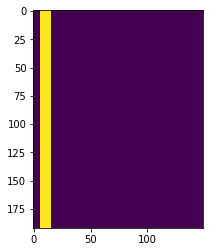

In [8]:
nz = 150 - 20
plt.imshow(count[0,0,0,:,:])
plt.show()

In [ ]:
print(count.sum().item())
print(np.prod(count.shape))

In [15]:
print((16 - 152%16)/int(150/16))
print((16 - 152%16)%int(150/16))

0.8888888888888888
8


In [ ]:
151 + 9

In [20]:
151 // 16

9

In [24]:
9*(16+1) 

153

In [23]:
9//9

1

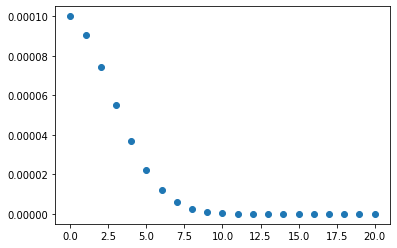

In [31]:
lr = 1e-4
ex = [lr]
n = [i for i in range(1,21)]
k = 0.1
for i in n:
    ex.append(ex[-1]*np.exp(-k*i))
n = [0]+n
plt.plot(n,ex, 'o')
plt.show()

In [32]:
ex

[0.0001,
 9.048374180359596e-05,
 7.408182206817178e-05,
 5.4881163609402636e-05,
 3.678794411714423e-05,
 2.2313016014842984e-05,
 1.224564282529819e-05,
 6.081006262521796e-06,
 2.7323722447292555e-06,
 1.1108996538242303e-06,
 4.086771438464066e-07,
 1.360368037547893e-07,
 4.097349789797865e-08,
 1.1166580849011467e-08,
 2.7536449349747137e-09,
 6.144212353328205e-10,
 1.2404950799567118e-10,
 2.266180127765709e-11,
 3.745970556295246e-12,
 5.602796437537261e-13,
 7.582560427911898e-14]

In [ ]:
exit(0)

## transformers

In [ ]:
w, h = 256,256
trans = ut2d.u_transformers_2D(filters = [4,8,16,32,64], trans_shape=(64,16,16), n_classes=2,in_channels=1).cuda()
x = torch.from_numpy(np.random.rand(2,1,w, h)).float().cuda()
y = trans(x)

In [ ]:
32*16

In [ ]:
(1024*((512/(2**4)))**2)/(1000**2)

In [ ]:
(512*(512/(2**3))**2)/(1000**2)

In [ ]:
4398046511104/(1000**3)

In [ ]:
[i for i in [[1,2,3],[6,5,4],[7,8,9]] ]

--------------------

In [ ]:
def softDice(pred, target, smoothing=1, nonSquared=False):
    intersection = (pred * target).sum(dim=(1, 2, 3))
    if nonSquared:
        union = (pred).sum() + (target).sum()
    else:
        union = (pred * pred).sum(dim=(1, 2, 3)) + (target * target).sum(dim=(1, 2, 3))
    dice = (2 * intersection + smoothing) / (union + smoothing)

    #fix nans
    dice[dice != dice] = dice.new_tensor([1.0])

    return dice.mean()

def dice(pred, target):
    predBin = (pred > 0.5).float()
    return softDice(predBin, target, 0, True).item()

In [ ]:
y = torch.from_numpy(np.ones((1,1,80,80,32)))
p = torch.from_numpy(np.ones((1,1,80,80,32)))

In [ ]:
dice(y,p)

### Reversible

In [ ]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import expconfigs.multi_atlas_revunet_01_v2 as cfg_rev
excfg_rev = cfg_rev.ExpConfig()
nr = (count_parameters(excfg_rev.net))
print(excfg_rev.experiment_name)

### Classic

In [ ]:
import expconfigs.multi_atlas_unet_res01_v2 as cfg_cla
excfg_cla = cfg_cla.ExpConfig()
nc = (count_parameters(excfg_cla.net))

### Compare

In [ ]:
print("rev :", nr)
print("cla :", nc)
print("nc/nr :", nc/nr)
print("nr/nc :", nr/nc)
print('min :', min(nc/nr, nr/nc))

In [ ]:
print("rev :", nr)
print("cla :", nc)
print("nc/nr :", nc/nr)
print("nr/nc :", nr/nc)
print('min :', min(nc/nr, nr/nc))

In [ ]:
print("rev :", nr)
print("cla :", nc)
print("nc/nr :", nc/nr)
print("nr/nc :", nr/nc)
print('min :', min(nc/nr, nr/nc))